## Install & Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install -U ultralytics
!pip install git+https://github.com/openai/CLIP.git

     ---------------------------------------- 0.0/610.8 kB ? eta -:--:--
     ----- --------------------------------- 92.2/610.8 kB 2.6 MB/s eta 0:00:01
     ------------ ------------------------- 204.8/610.8 kB 2.5 MB/s eta 0:00:01
     ----------------- -------------------- 276.5/610.8 kB 2.4 MB/s eta 0:00:01
     -------------------------- ----------- 419.8/610.8 kB 2.4 MB/s eta 0:00:01
     --------------------------------- ---- 532.5/610.8 kB 2.4 MB/s eta 0:00:01
     -------------------------------------- 610.8/610.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.159
    Uninstalling ultralytics-8.0.159:
      Successfully uninstalled ultralytics-8.0.159
  Cloning https://github.com/openai/CLIP.git to c:\users\adnan\appdata\local\temp\pip-req-build-tx_evr3q


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [44]:
import os
import json
import pickle
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from clip import clip
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.models import resnet50
from torchvision import transforms
import spacy

## 1. Downloading Dataset

In [ ]:
!pip install -qqq gdown
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq

In [ ]:
%%bash
tar -xvf /content/refcocog.tar.gz
rm /content/refcocog.tar.gz

## 2. Understanding the RefCOCOg Dataset

In [45]:
# Set the path to the dataset directory
dataset_dir = os.path.join(os.getcwd(), "dataset", "refcocog")
dataset_dir

'D:\\Study\\Trento University Study\\Samester-2\\Deep Learning\\Visual_Grounding_Project\\dataset\\refcocog'

In [46]:
annotations_file = os.path.join(dataset_dir, 'annotations', 'instances.json')
refs_file = os.path.join(dataset_dir, "annotations", "refs(umd).p")
images_folder = os.path.join(dataset_dir, "images")

In [47]:
with open(annotations_file, "r") as f:
    instances_ = json.load(f)

with open(refs_file, "rb") as f:
    refs_data = pickle.load(f)

In [48]:
instances_.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [49]:
instances_["images"][1]

{'license': 3,
 'file_name': 'COCO_train2014_000000524291.jpg',
 'coco_url': 'http://mscoco.org/images/524291',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 09:59:07',
 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg',
 'id': 524291}

In [50]:
instances_["annotations"][0]

{'segmentation': [[21.11,
   239.09,
   16.31,
   274.6,
   198.65,
   349.45,
   240.87,
   336.98,
   320.52,
   293.79,
   334.91,
   248.69,
   357.95,
   273.64,
   353.15,
   289.0,
   398.25,
   267.88,
   437.6,
   251.57,
   412.65,
   228.54,
   240.87,
   210.31,
   219.76,
   141.21,
   113.24,
   153.69,
   63.34,
   156.57,
   26.87,
   169.04]],
 'area': 48667.84089999999,
 'iscrowd': 0,
 'image_id': 131074,
 'bbox': [16.31, 141.21, 421.29, 208.24],
 'category_id': 65,
 'id': 318235}

In [51]:
instances_["categories"][0:5]

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]

In [52]:
refs_data[0]

{'image_id': 380440,
 'split': 'test',
 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'],
   'raw': 'the man in yellow coat',
   'sent_id': 8,
   'sent': 'the man in yellow coat'},
  {'tokens': ['skiier', 'in', 'red', 'pants'],
   'raw': 'Skiier in red pants.',
   'sent_id': 9,
   'sent': 'skiier in red pants'}],
 'file_name': 'COCO_train2014_000000380440_491042.jpg',
 'category_id': 1,
 'ann_id': 491042,
 'sent_ids': [8, 9],
 'ref_id': 0}

In [53]:
# get all annotation data for the image_id=380440
sample_annotations = instances_["annotations"]
sample_annotations_df = pd.DataFrame(sample_annotations)
sample_annotations_df[sample_annotations_df["image_id"] == 380440]

,segmentation,area,iscrowd,image_id,bbox,category_id,id
96094,"[[362.48, 277.14, 332.06, 210.39, 335.44, 165....",15877.13600,0,380440,"[228.98, 41.4, 141.95, 270.38]",1,470048
96095,"[[386.14, 222.22, 397.97, 158.85, 436.84, 158....",10315.83825,0,380440,"[374.31, 65.06, 136.04, 201.94]",1,491042
96096,"[[348.53, 298.33, 385.28, 261.58, 384.97, 269....",1658.13485,0,380440,"[244.21, 251.3, 141.07, 90.63]",35,607150
96097,"[[304.34, 200.09, 291.38, 190.07, 293.74, 195....",614.97200,0,380440,"[291.38, 190.07, 185.19, 68.27]",35,608103
96098,"[[460.99, 102.16, 454.66, 99.0, 448.86, 97.68,...",471.07410,0,380440,"[416.16, 95.57, 66.98, 58.28]",27,1417747
96099,"[[295.86, 95.78, 290.84, 103.6, 288.6, 100.25,...",142.09260,0,380440,"[288.6, 75.67, 54.76, 27.93]",27,1421553


## 3. RefCOCOg Dataset Class

In [54]:
# method to convert bbox from [x, y, w, h] to [x1, y1, x2, y2]
def convert_bbox(bb):
    x, y, w, h = bb
    x1_cord, y1_cord = x, y
    x2_cord, y2_cord = x + w, y + h

    return [x1_cord, y1_cord, x2_cord, y2_cord]

In [55]:
class RefCOCOgDataset(Dataset):
    def __init__(self, dataset_dir_, split='train', no_of_samples=None):
        self.dataset_dir = dataset_dir
        self.images_dir = os.path.join(dataset_dir_, "images")
        self.annotations_dir = os.path.join(dataset_dir_, "annotations")
        self.instances_path = os.path.join(self.annotations_dir, "instances.json")
        self.refs_path = os.path.join(self.annotations_dir, "refs(umd).p")

        with open(self.instances_path, "r") as file:
            self.instances_df = pd.DataFrame(json.load(file)["annotations"])
            self.instances_df = self.instances_df.reset_index(drop=True)

        with open(self.refs_path, "rb") as file:
            self.refs_df = pd.DataFrame(pickle.load(file))
            # explode the sentences column to get one row for each sentence
            # self.refs_df = self.refs_df.explode("sentences")
            self.refs_df = self.refs_df.reset_index(drop=True)

        # merge the instances and refs data frames based on the ann_id column and id column
        self.data = pd.merge(self.refs_df, self.instances_df, left_on="ann_id", right_on="id")
        self.data = self.data.explode(['sentences', 'sent_ids'])
        self.data = self.data.reset_index()
        self.data.drop(columns=['index'], inplace=True)
        self.data['sentences'] = self.data['sentences'].apply(lambda x: x['raw'])

        # filter out the data frame based on the split
        self.data = self.filter_df(split, drop_unnecessary_cols=True)

        # convert the bbox from [x, y, w, h] to [x1, y1, x2, y2]
        self.data['bbox'] = self.data['bbox'].apply(lambda x: convert_bbox(x))
        
        if no_of_samples:
            # get first n samples from the data frame
            self.data = self.data[:no_of_samples]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]

    def filter_df(self, split, drop_unnecessary_cols=True):
        if drop_unnecessary_cols:
            drop_cols = ['category_id_x', 'ann_id', 'sent_ids', 'iscrowd', 'image_id_y',
                         'image_id_x', 'segmentation', 'id', 'category_id_y', 'ref_id', 'area']
            self.data = self.data.drop(columns=drop_cols)

        return self.data[self.data['split'] == split]

    def get_annotation_data(self, idx):
        return self.instances_df.iloc[idx]

    def get_image_data(self, idx):
        return self.refs_df.iloc[idx]

## 5. Prepare the Dataset

### 5.1. Create RefCOCOg Dataset Instance

In [56]:
# create an instance of the RefCOCOgDataset class for the train/val/test splits
refcocog_dataset_train = RefCOCOgDataset(dataset_dir, split='train', no_of_samples=15000)
refcocog_dataset_val = RefCOCOgDataset(dataset_dir, split='val', no_of_samples=1500)
refcocog_dataset_test = RefCOCOgDataset(dataset_dir, split='test', no_of_samples=4000)

In [57]:
len(refcocog_dataset_train), len(refcocog_dataset_val), len(refcocog_dataset_test)

(15000, 1500, 4000)

In [58]:
refcocog_dataset_test.data.head(10)

,split,sentences,file_name,bbox
0,test,the man in yellow coat,COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 510.35, 267.0]"
1,test,Skiier in red pants.,COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 510.35, 267.0]"
2,test,There is red colored truck in between the othe...,COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 598.5600000000001, 373.86]"
3,test,A shiny red vintage pickup truck,COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 598.5600000000001, 373.86]"
4,test,A apple desktop computer,COCO_train2014_000000478885_124383.jpg,"[338.8, 82.19, 486.14, 239.56]"
5,test,the white IMac computer that is also turned on,COCO_train2014_000000478885_124383.jpg,"[338.8, 82.19, 486.14, 239.56]"
6,test,A girl wearing glasses and a pink shirt,COCO_train2014_000000323240_192943.jpg,"[45.2, 166.76, 192.64999999999998, 346.49]"
7,test,an Asian girl with a pink shirt eating at the ...,COCO_train2014_000000323240_192943.jpg,"[45.2, 166.76, 192.64999999999998, 346.49]"
8,test,WOMAN IN COVERALLS,COCO_train2014_000000041700_197196.jpg,"[496.24, 82.81, 579.04, 251.52]"
9,test,a person wearing overalls,COCO_train2014_000000041700_197196.jpg,"[496.24, 82.81, 579.04, 251.52]"


### 5.3. Create DataLoader Instances

In [59]:
# collate function for the RefCOCOg dataset loader
def collate_fn(batch_):
    _, img_, query, bboxes = zip(*batch_)

    return img_, query, bboxes

In [60]:
# create a DataLoader instance for the train/val/test splits
train_dataloader = DataLoader(refcocog_dataset_train, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_dataloader = DataLoader(refcocog_dataset_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
test_dataloader = DataLoader(refcocog_dataset_test, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [61]:
next(iter(train_dataloader))

[['Two woman one in black eatting and the other has a white shirt at the desk'],
 ['COCO_train2014_000000519404_1241542.jpg'],
 [[0.0, 45.95, 238.92, 454.59]]]

## 6. Utility Functions/Classes

In [62]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append

    return string

In [63]:
def crop_image(image, bb):
    """
    Function to crop the image with the given bounding boxes and save them to the disk.
    :param image: PIL image object
    :param bb: list of bounding boxes [x, y, w, h] for the current image
    :return: cropped image
    """
    x1_cord, y1_cord, x2_cord, y2_cord = bb[0:4]

    cropped_image = image.crop((x1_cord, y1_cord, x2_cord, y2_cord))

    return cropped_image

In [64]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    """
    Convert bounding box format from [cx, cy, w, h] to [x1, y1, x2, y2]
    :param x: bounding boxes in [cx, cy, w, h] format, with values ranging from 0 to 1
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    """
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    """
    Convert bounding box scales (tensor) to image scales
    :param out_bbox: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    :param size: PIL image size
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to image dimension
    """
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)  # [x1, y1, x2, y2] format
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)  # rescale to image scales
    return b

def detr_plot_results(pil_img, results_, query=None):
    """
    Show image results
    :param pil_img: PIL image
    :param results_: inference results
    :param query: query string
    """
    # colors for visualization
    colors = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for res, color in zip(results_, colors * 100):
        label = res['label']
        score = res['score']
        box = res['box']
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color=color, linewidth=3))
        text = f'{label}: {score}'
        ax.text(box[0], box[1], text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
        
    if query is not None:
        # add title with query string
        plt.title(query, fontdict={'fontsize': 20})
        
    plt.axis('off')
    plt.show()

In [22]:
def pad_image(pil_img):
    """
    Preprocess the input image to fit CLIP's input size of 224x224 pixels.
    
    The function pads the image if its dimensions are smaller than 224x224, 
    using the average color of the original image. Post padding, the image 
    is resized to the exact required dimensions of 224x224 pixels.
    
    Parameters:
    ----------
    pil_img : PIL.Image
        The input image that needs to be processed.

    Returns:
    -------
    PIL.Image
        The processed image with dimensions 224x224 pixels.
    """
    # Calculate average color
    avg_color_per_row = np.average(pil_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    old_image_width, old_image_height = pil_img.size

    new_image_width = max(old_image_width, 224)
    new_image_height = max(old_image_height, 224)

    color = avg_color
    result = np.full((new_image_height, new_image_width, 3), color, dtype=np.uint8)

    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = pil_img

    pil_img = Image.fromarray(result)
    pil_img = pil_img.resize((224, 224))
    return pil_img


In [23]:
def calculate_iou(predicted_bbox, gt_bbox_):
    """
    Function to calculate the intersection over union (IoU) between two bounding boxes
    :param predicted_bbox: list of predicted bounding boxes
    :param gt_bbox_: list of ground truth bounding boxes
    :return: list of IoU values
    """
    # Extract coordinates of each bounding box
    x1_coord, y1_coord, x2_coord, y2_coord = predicted_bbox
    x3_coord, y3_coord, x4_coord, y4_coord = gt_bbox_

    # Calculate coordinates of intersection rectangle
    x5_coord = max(x1_coord, x3_coord)
    y5_coord = max(y1_coord, y3_coord)
    x6_coord = min(x2_coord, x4_coord)
    y6_coord = min(y2_coord, y4_coord)

    # Calculate width and height of intersection rectangle
    width_ = max(0, x6_coord - x5_coord)
    height_ = max(0, y6_coord - y5_coord)

    # Calculate areas of bounding boxes and intersection rectangle
    predicted_bbox_area = (x2_coord - x1_coord) * (y2_coord - y1_coord)
    gt_bbox_area = (x4_coord - x3_coord) * (y4_coord - y3_coord)
    intersection_area = width_ * height_

    union_area = predicted_bbox_area + gt_bbox_area - intersection_area

    iou = intersection_area / union_area

    return iou

In [24]:
class Recall:
    def __init__(self, tp=0, fn=0):
        self.tp = tp
        self.fn = fn

    def update(self, tp):
        if tp:  # if true positive then update tp
            self.tp += 1
        else:  # if false negative then update fn
            self.fn += 1

    def calculate(self):
        return self.tp / (self.tp + self.fn)

    def reset(self):
        self.tp = 0
        self.fn = 0

In [25]:
class Metrics:
    def __init__(self, model, eval_desc, threshold=0.5, img_size=224):
        self.model = model
        self.eval_desc = eval_desc
        self.threshold = threshold
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

        self.recall = Recall()
        self.iou_list = []
        self.cosine_similarity_list = []
        self.euclidean_distance_list = []

    def update(self, predicted_bb, gt_bb, predicted_img, gt_img):
        with torch.no_grad():
            predicted_img_padded = pad_image(predicted_img)
            gt_img_padded = pad_image(gt_img)
            predicted_img_tensor = self.transform(predicted_img_padded).unsqueeze(0).cuda()
            gt_img_tensor = self.transform(gt_img_padded).unsqueeze(0).cuda()

            predicted_img_embedding = self.model.encode_image(predicted_img_tensor)
            gt_img_embedding = self.model.encode_image(gt_img_tensor)

        cosine_similarity_ = nn.functional.cosine_similarity(predicted_img_embedding, gt_img_embedding)
        euclidean_distance_ = nn.functional.pairwise_distance(predicted_img_embedding, gt_img_embedding)

        predicted_bb = predicted_bb[:4]
        gt_bb = gt_bb[:4]
        predicted_bb = torch.tensor(predicted_bb)
        gt_bb = torch.tensor(gt_bb)

        # iou_ = ops.box_iou(predicted_bb.unsqueeze(0), gt_bb.unsqueeze(0)).squeeze(0).squeeze(0)
        iou_ = calculate_iou(predicted_bb, gt_bb)
        self.iou_list.append(iou_)

        self.recall.update(iou_ > self.threshold)
        self.cosine_similarity_list.append(cosine_similarity_)
        self.euclidean_distance_list.append(euclidean_distance_)

    def calculate(self):
        iou_mean = torch.mean(torch.stack(self.iou_list))
        cosine_similarity_mean = torch.mean(torch.stack(self.cosine_similarity_list))
        euclidean_distance_mean = torch.mean(torch.stack(self.euclidean_distance_list))

        return self.recall.calculate(), iou_mean, cosine_similarity_mean, euclidean_distance_mean

    def __str__(self):
        return f"Recall: {self.recall.calculate():.4f}, IoU: {self.calculate()[1]:.4f}, Cosine Similarity: {self.calculate()[2]:.4f}, Euclidean Distance: {self.calculate()[3]:.4f}"

    def get_recall(self):
        return self.recall.calculate()

    def get_iou(self):
        return torch.mean(torch.stack(self.iou_list))

    def get_cosine_similarity(self):
        return torch.mean(torch.stack(self.cosine_similarity_list))

    def get_euclidean_distance(self):
        return torch.mean(torch.stack(self.euclidean_distance_list))

    def reset(self):
        self.recall.reset()
        self.iou_list = []
        self.cosine_similarity_list = []
        self.euclidean_distance_list = []

    def save(self):
        df_ = pd.DataFrame({
            "iou": [iou.cpu().item() for iou in self.iou_list],
            "cosine_similarity": [cosine_similarity.cpu().item() for cosine_similarity in self.cosine_similarity_list],
            "euclidean_distance": [euclidean_distance.cpu().item() for euclidean_distance in self.euclidean_distance_list]
        })

        df_.to_csv(self.eval_desc + "_iou.csv", index=False)

In [26]:
def adjust_tensor_size(tensor, target_size):
    if tensor.shape[0] < target_size:
        padding_size = target_size - tensor.shape[0]
        padding = torch.zeros(padding_size, *tensor.shape[1:]).to(tensor.device)
        tensor = torch.cat([tensor, padding], dim=0)
    else:
        tensor = tensor[:target_size]
    return tensor

## 8. DETR (End-to-End Object Detection with Transformers)

In [27]:
class DETRDetector(nn.Module):
    """
    DETR implementation with the following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine) 
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    Only batch size 1 supported.
    """
    def __init__(self, th=0.7, hidden_dim=256, n_heads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        
        self.classes = [
            'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
            'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
            'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
            'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
            'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
            'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
            'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
            'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
            'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush'
        ]
        
        self.th = th

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(hidden_dim, n_heads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        self.linear_class = nn.Linear(hidden_dim, len(self.classes) + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs, img_size):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        height_, width_ = h.shape[-2:]
        try:
            pos = torch.cat([
                self.col_embed[:width_].unsqueeze(0).repeat(height_, 1, 1),
                self.row_embed[:height_].unsqueeze(1).repeat(1, width_, 1),
            ], dim=-1).flatten(0, 1).unsqueeze(1)
        except RuntimeError:
            # adjust positional encodings size
            col_embed_new = adjust_tensor_size(self.col_embed, width_)
            row_embed_new = adjust_tensor_size(self.row_embed, height_)
            
            # if col_embed or row_embed are nn.Parameter, ensure the adjusted tensors are as well
            if isinstance(self.col_embed, torch.nn.Parameter):
                col_embed_new = torch.nn.Parameter(col_embed_new)
            if isinstance(self.row_embed, torch.nn.Parameter):
                row_embed_new = torch.nn.Parameter(row_embed_new)
            
            # update positional encodings
            self.col_embed = col_embed_new
            self.row_embed = row_embed_new
            
            # construct positional encodings again with the adjusted positional encodings
            pos = torch.cat([
                self.col_embed[:width_].unsqueeze(0).repeat(height_, 1, 1),
                self.row_embed[:height_].unsqueeze(1).repeat(1, width_, 1),
            ], dim=-1).flatten(0, 1).unsqueeze(1)


        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        preds_logits = self.linear_class(h)
        probs = preds_logits.softmax(-1)[0, :, :-1]
        keep = probs.max(-1).values > self.th
        
        probs = probs[keep]
        boxes = self.linear_bbox(h).sigmoid()
        boxes = boxes[0, keep]
        
        bboxes = rescale_bboxes(boxes, img_size)
        
        results = []
        for prob, box in zip(probs, bboxes):
            results.append(
                {'label': self.classes[prob.argmax()], 'score': f'{prob[prob.argmax()]:0.2f}', 'box': box.tolist()}
            )
        return results

## 7. Visual Grounding Base Pipeline

### 7.1. Visual Grounding Base Pipeline with YOLOv5/YOLOv8 and CLIP

In [65]:
class YOLOCLIPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', yolo_model_variant='yolov5s', model_desc="baseline", detection_threshold=0.7, iou_threshold=0.45):
        super(YOLOCLIPVisualGroundingBaselineNN, self).__init__()
        
        self.device = device
        self.yolo_model_variant = yolo_model_variant
        
        if yolo_model_variant == 'yolov5s':
            self.yolo_model = torch.hub.load('ultralytics/yolov5', yolo_model_variant, pretrained=True).to(device)
            self.yolo_model.conf = detection_threshold
            self.yolo_model.iou = iou_threshold
        elif yolo_model_variant == 'yolov8s':
            self.yolo_model = YOLO(yolo_model_variant).to(device)
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")
        
        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")
        if self.yolo_model_variant == 'yolov5s':
            yolo_detections = self.yolo_model(img_path)
            predicted_boxes = yolo_detections.xyxy[0].cpu().numpy().tolist()
        elif self.yolo_model_variant == 'yolov8s':
            yolo_detections = self.yolo_model(img_path)
            predicted_boxes = [box.xyxy[0].tolist() for box in yolo_detections[0].boxes]
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")
        
        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()
            
        cropped_images_ = []
        for bb in predicted_boxes:
            cropped_images_.append(pad_image(crop_image(image, bb)))
        
        # save cropped images to disk
        import cv2
        for idx, cropped_image in enumerate(cropped_images_):
            cv2.imwrite(f"cropped_image_{idx}.jpg", np.array(cropped_image))

        cropped_images_features = []
        for cropped_image in cropped_images_:
            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)
            cropped_images_features.append(cropped_image_features)

        # Batch process cropped images
        try:
            cropped_images_tensor = torch.cat(cropped_images_features)  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_images_tensor.cpu().numpy()  # convert cropped images features tensor to NumPy array
        similarities = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multiplication between text and image features
        try:
            max_similarity_idx = np.argmax(similarities)  # get the index of the highest similarity
        except ValueError:  # if the similarities array is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        return cropped_images_[max_similarity_idx], predicted_boxes[max_similarity_idx]

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

### 7.2. Visual Grounding Base Pipeline with DETR and CLIP

In [66]:
class DETRCLIPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', detector_th=0.5, model_desc="baseline"):
        super(DETRCLIPVisualGroundingBaselineNN, self).__init__()
        
        self.device = device
        
        self.detr_detector_model = DETRDetector(th=detector_th)
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
            map_location=self.device, check_hash=True)
        self.detr_detector_model.load_state_dict(state_dict)
        self.detr_detector_model.eval()
        
        self.detr_transform = transforms.Compose([
            transforms.Resize(800),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")
        
        img = self.detr_transform(image).unsqueeze(0)
        results = self.detr_detector_model(img, image.size)
        
        bboxes = [result['box'] for result in results]
         
        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()

        cropped_images_ = []
        for bb in bboxes:
            cropped_images_.append(crop_image(image, bb))

        cropped_images_features = []
        for cropped_image in cropped_images_:
            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)
            cropped_images_features.append(cropped_image_features)

        # Batch process cropped images
        try:
            cropped_images_tensor = torch.cat(cropped_images_features)  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_images_tensor.cpu().numpy()  # convert cropped images features tensor to NumPy array
        similarities = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multiplication between text and image features
        try:
            max_similarity_idx = np.argmax(similarities)  # get the index of the highest similarity
        except ValueError:  # if the similarities array is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        return cropped_images_[max_similarity_idx], bboxes[max_similarity_idx]

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

### 7.3 Visual Grounding Base Pipeline with YOLOv5/YOLOv8 and CLIP + NLP

In [67]:
# Preprocessing function
def remove_of(sent):
    """
    Removes any "of" phrases from the sentence to improve entity extraction
    :param sent: The sentence to remove "of" phrases from
    :return: The sentence with "of" phrases removed
    """
    # Remove any "of" phrases from the sentence to improve entity extraction
    of_phrases = [
        "the side of", "the handle of", "the bunch of", "the corner of",
        "the top of", "the bottom of", "the front of", "the back of",
        "the edge of", "the middle of", "the end of", "the tip of",
        "the base of", "the center of", "the surface of", "the middle of",
        "the left of", "the right of", "the rear of", "the rim of"
    ]
    
    for phrase in of_phrases:
        if phrase in sent:
            index = sent.find(phrase)
            sent = sent[index + len(phrase):]
            return sent.strip()  # Stripping any leading or trailing whitespace
    return sent

In [89]:
class YOLOCLIPNLPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', yolo_model_variant='yolov5s', model_desc="baseline", 
                 detection_threshold=0.7, iou_threshold=0.45, clip_th=0.12):
        super(YOLOCLIPNLPVisualGroundingBaselineNN, self).__init__()
        
        self.device = device
        self.yolo_model_variant = yolo_model_variant
        self.clip_th = clip_th
        self.detection_threshold = detection_threshold
        self.iou_threshold = iou_threshold
        
        if yolo_model_variant == 'yolov5s':
            self.yolo_model = torch.hub.load('ultralytics/yolov5', yolo_model_variant, pretrained=True).to(device)
            self.yolo_model.conf = detection_threshold
            self.yolo_model.iou = iou_threshold
            self.CLASSES = self.yolo_model.names
        elif yolo_model_variant == 'yolov8s':
            self.yolo_model = YOLO(yolo_model_variant).to(device)
            self.CLASSES = self.yolo_model.names
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")
        
        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)
        
        self.nlp = spacy.load("en_core_web_sm")

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def get_embedding_for_text(self, text):
        """
        get embeddings for text
        :param text: str
        :return: torch.tensor
        """
        tokens = clip.tokenize([text]).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(tokens).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
        return text_features
    
    def compute_similarity(self, text1, text2):
        """
        compute similarity between two texts
        :param text1: str
        :param text2: str
        :return: float
        """
        text1_embedding = self.get_embedding_for_text(text1)
        text2_embedding = self.get_embedding_for_text(text2)
        
        similarity = (text1_embedding @ text2_embedding.T).squeeze().item()
        return similarity
    
    def filter_detector_predictions(self, detector_results, subject_enr):
        """
        Filters the detector results by the subject/entities
        :param detector_results: bbox, classes, scores
        :param subject_enr: list of subjects or entities to filter the yolo detections by calculating similarity (text-to-text)
        :return: filtered results (bbox, classes, scores)
        """
        predictions_with_sim_scores = list()
        for bb, cls, score in zip(*detector_results):
            # calculate the similarity between the subject and each class or entity
            for enr in subject_enr:
                sim_score = self.compute_similarity(enr, "this is a " + cls)
                predictions_with_sim_scores.append((bb, cls, score, sim_score))
                
        # sort the predictions by the similarity score
        predictions_with_sim_scores.sort(key=lambda x: x[-1], reverse=True)
        
        return predictions_with_sim_scores[0]
    
    def get_root_or_subject(self, sent):
        """
        Extracts the root or subject of a sentence
        :param sent: The sentence to extract the root or subject from
        :return: The root or subject of the sentence
        """
        sent = sent.lower()
        
        starting_phrases = [
            "there is", "this is", "there are", "these are", "it is", "there's", "there're", "it's", "this's"
        ]
        
        # Remove the starting phrase from the sentence if it exists
        for phrase in starting_phrases:
            if sent.startswith(phrase):
                sent = sent[len(phrase):]
                break
                
        article_phrases = ["a ", "an ", "the "]
        
        # Remove any articles from the sentence to improve entity extraction
        for phrase in article_phrases:
            if sent.startswith(phrase):
                sent = sent[len(phrase):]
                break
                
        # Remove any "of" phrases from the sentence to improve entity extraction
        sent = remove_of(sent)
        
        # Extract the root or subject of the sentence
        doc = self.nlp(sent)
        for token in doc:
            # Check for nominal subjects
            if token.dep_ in ["nsubj", "nsubjpass"]:
                return token.text
            
        # If no nominal subject, return the root of the sentence
        return [token.text for token in doc if token.dep_ == "ROOT"]
    
    def extract_entities(self, sent):
        """
        Extracts the entities from a sentence
        :param sent: str
        :return: list
        """
        doc = self.nlp(sent)
        entities = [ent.text for ent in doc.ents] + [noun_chunk.text for noun_chunk in doc.noun_chunks]
        return entities
    
    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")
        if self.yolo_model_variant == 'yolov5s':
            yolo_detections = self.yolo_model(img_path)
            pred_boxes = yolo_detections.xyxy[0].cpu().numpy().tolist()
            predicted_classes = [self.CLASSES[boxes[-1]] for boxes in pred_boxes]
            predicted_scores = [boxes[-2] for boxes in pred_boxes]
        elif self.yolo_model_variant == 'yolov8s':
            yolo_detections = self.yolo_model(img_path, conf=self.detection_threshold, iou=self.iou_threshold)
            pred_boxes = [box.xyxy[0].tolist() for box in yolo_detections[0].boxes]
            predicted_classes = [self.CLASSES[int(c)] for c in yolo_detections[0].boxes.cls]
            predicted_scores = yolo_detections[0].boxes.conf.tolist()
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")
        
        predicted_boxes = pred_boxes
        if len(predicted_boxes) == 0:
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box
        
        # apply filter on textual query -> detect subject/entities
        subject = self.get_root_or_subject(textual_query)
        # print("Subject: ", subject)
        
        # filter yolo detections by subject/entities
        predicted_boxes = self.filter_detector_predictions(
            detector_results=(predicted_boxes, predicted_classes, predicted_scores), 
            subject_enr=subject)[0]
        
        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()
            
        cropped_image = pad_image(crop_image(image, predicted_boxes))
        
        cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
        with torch.no_grad():
            cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
        cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)

        # Batch process cropped images
        try:
            cropped_image_tensor = torch.cat([cropped_image_features])  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_image_tensor.cpu().numpy()  # cropped img features tensor to NumPy array
        similarity = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multi between text and image features
        
        if similarity > self.clip_th:
            return cropped_image, predicted_boxes
        else:
            # if the similarity is less than the threshold, try to extract entities from the sentence and filter the yolo detections by entities
            entities = self.extract_entities(textual_query)
            
            # filter yolo detections by entities
            predicted_boxes = self.filter_detector_predictions(
                detector_results=(pred_boxes, predicted_classes, predicted_scores), 
                subject_enr=entities)[0]
            
            cropped_image = pad_image(crop_image(image, predicted_boxes))
            
            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)
            
            # Batch process cropped images
            try:
                cropped_image_tensor = torch.cat([cropped_image_features])  # concatenate along the batch dimension
                text_features_ = text_features_.cuda()
                text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
            except RuntimeError:  # if the cropped images list is empty
                return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox
            
            # Calculate similarities using NumPy operations
            text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
            cropped_images_features_np = cropped_image_tensor.cpu().numpy()  # cropped img features tensor to NumPy array
            similarity = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multi between text and image features
            
            if similarity > self.clip_th:
                return cropped_image, predicted_boxes
            else:
                return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

### 7.2. Create Baseline Instance YOLOv5/YOLOv8 and CLIP

In [38]:
baseline_model_yolo_clip = YOLOCLIPVisualGroundingBaselineNN(model_desc="Baseline_RN50_yolov5s_train")  # Default model is RN50
# baseline_model_yolo_clip = YOLOCLIPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_yolov5s_train")

Using cache found in C:\Users\adnan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-8-20 Python-3.9.16 torch-2.1.0.dev20230609+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### 7.3. Create Baseline Instance DETR and CLIP

In [80]:
baseline_model_detr_clip = DETRCLIPVisualGroundingBaselineNN(model_desc="Baseline_ViT-B32_detr_train")  # Default model is RN50
# baseline_model_detr_clip = DETRCLIPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_detr_train")

### 7.4. Create Baseline Instance YOLOv5/YOLOv8 and CLIP + NLP

In [90]:
baseline_model_yolo_clip_nlp = YOLOCLIPNLPVisualGroundingBaselineNN(
    clip_model_variant='ViT-B/32', yolo_model_variant='yolov8s', 
    model_desc="Baseline_RN50_yolov5s_train")  # Default model is RN50
# baseline_model_yolo_clip_nlp = YOLOCLIPNLPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_yolov5s_train")

## 8. Evaluation

### 8.1. Evaluate the baseline: YOLOv5/YOLOv8 and CLIP on a single image

D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000374391.jpg
Predicted Bounding Box: [348.9093933105469, 301.9761962890625, 443.2050476074219, 418.247802734375]
Ground Truth Bounding Box: [392.41, 187.79, 577.08, 400.92999999999995]
Sentence: a brown bear near a soda bottle


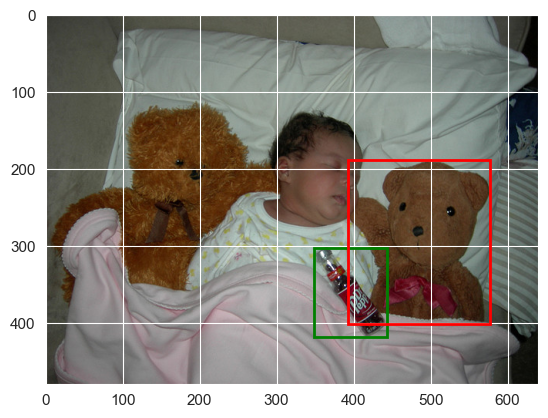

Recall: 0.0000, IoU: 0.1110, Cosine Similarity: 0.6855, Euclidean Distance: 1.6553


In [39]:
baseline_model_yolo_clip.metrics.reset()
sample_input = refcocog_dataset_test[20]

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

crop = original_img.crop((x1, y1, x2, y2))
%matplotlib inline
plt.imshow(original_img)

img, bbox = baseline_model_yolo_clip.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_yolo_clip.get_results())

### 8.2. Evaluate the baseline: DETR and CLIP on a single image

D:\Study\Trento University Study\Samester-2\Deep Learning\DL\DL Project\dataset\refcocog\images\COCO_train2014_000000374391.jpg
Predicted Bounding Box: [171.61846923828125, 125.66008758544922, 605.3941040039062, 475.595458984375]
Ground Truth Bounding Box: [392.41, 187.79, 577.08, 400.92999999999995]
Sentence: a brown bear near a soda bottle


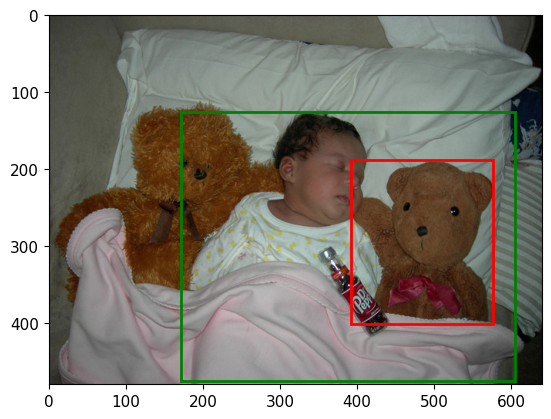

Recall: 0.0000, IoU: 0.2593, Cosine Similarity: 0.6655, Euclidean Distance: 2.0176


In [173]:
baseline_model_detr_clip.metrics.reset()
sample_input = refcocog_dataset_test[20]

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

%matplotlib inline
plt.imshow(original_img)

# predict the bounding box for the given image and sentence
img, bbox = baseline_model_detr_clip.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_detr_clip.get_results())

### 8.3. Evaluate the baseline: YOLOv5/YOLOv8 and CLIP + NLP on a single image

D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000200213.jpg



image 1/1 D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000200213.jpg: 448x640 4 persons, 2 bottles, 1 pizza, 34.0ms
Speed: 4.0ms preprocess, 34.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Predicted Bounding Box: [318.4468994140625, 0.0, 639.7257080078125, 419.074951171875]
Ground Truth Bounding Box: [0.0, 177.22, 121.39, 388.41999999999996]
Sentence: A brown and black woven purse, being held by an older woman in a blue shirt.


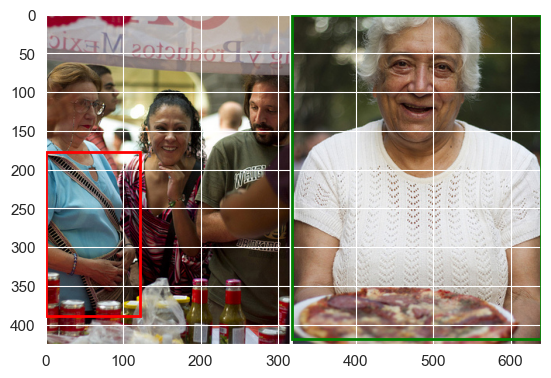

Recall: 0.0000, IoU: 0.0000, Cosine Similarity: 0.5703, Euclidean Distance: 9.7578


In [91]:
baseline_model_yolo_clip_nlp.metrics.reset()
sample_input = refcocog_dataset_train[251]  #20

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

%matplotlib inline
plt.imshow(original_img)

# predict the bounding box for the given image and sentence
_, bbox = baseline_model_yolo_clip_nlp.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_yolo_clip_nlp.get_results())

### 8.3. Evaluate the baseline: YOLOv5/YOLOv8 and CLIP on the Dataloader

In [ ]:
baseline_model_yolo_clip.metrics.reset()
# evaluate the model on the dataloader
for i, batch in enumerate(tqdm(train_dataloader)):
    sentences_, images_, bboxes_ = batch
    for sentence_, image_, bbox_ in zip(sentences_, images_, bboxes_):
        image_path = os.path.join(images_folder, split_string(image_))
        original_img = Image.open(image_path).convert("RGB")
        baseline_model_yolo_clip.evaluate(image_path, sentence_, bbox_)

print(baseline_model_yolo_clip.get_results())

# save the metrics to the csv file
baseline_model_yolo_clip.metrics.save()

### 8.4. Evaluate the baseline: DETR and CLIP on the Dataloader

In [ ]:
baseline_model_detr_clip.metrics.reset()
# evaluate the model on the dataloader
for i, batch in enumerate(tqdm(train_dataloader)):
    sentences_, images_, bboxes_ = batch
    for sentence_, image_, bbox_ in zip(sentences_, images_, bboxes_):
        image_path = os.path.join(images_folder, split_string(image_))
        original_img = Image.open(image_path).convert("RGB")
        baseline_model_detr_clip.evaluate(image_path, sentence_, bbox_)

print(baseline_model_detr_clip.get_results())

# save the metrics to the csv file
baseline_model_detr_clip.metrics.save()